# Solución de problemas con KNN

En este tutorial aprenderás cómo crear un modelo de clasificación haciendo uso del algoritmo KNN (K vecinos más cercanos). En particular, realizarás una selección de hiperparámetros mediante una curva de validación, evaluando el mejor modelo de clasificación resultante. En este sentido, veremos cómo realizar los siguientes procesos:

1. Importar las librerías necesarias.
2. Cargar un conjunto de datos.
3. Explorar el conjunto de datos.
4. Limpiar y preparar los datos para el modelado.
5. Graficar una curva de validación para el hiperparámetro K.
6. Evaluar el mejor modelo resultante.

Utilizaremos el conjunto de datos correspondiente a la compra de seguros de viaje. En este problema queremos predecir si una persona va a comprar un seguro de viaje dependiendo de factores como su edad, salario, educación, entre otros.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `matplotlib`, `numpy` y `scikit-learn`. En particular, usaremos las siguientes clases y funciones para entrenar y evaluar el modelo de KNN:

* `KNeighborsClassifier()`: clase para crear el modelo de KNN.
* `StandardScaler()`: clase para estandarizar los datos.
* `validation_curve()`: función para generar las métricas de desempeño en una curva de validación.
* `classification_report()`: función para obtener un reporte con las métricas por clase.
* `plot_confusion_matrix()`: función para graficar la matriz de confusión.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import classification_report, plot_confusion_matrix

## 2. Carga de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data_raw = pd.read_csv('data/TravelInsurancePrediction.csv', sep=',')

Veamos los primeros datos del conjunto utilizando `head()`:

In [3]:
data_raw.head()

,Index,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Como puedes observar, nuestro conjunto de datos contiene cuatro variables categóricas: `Employment Type`, `GraduateOrNot`, `FrequentFlyer` y `EverTravelledAbroad`.

## 3. Exploración del conjunto de datos

Primero utilizaremos `data_raw.describe()` para obtener una descripción de las variables numéricas del conjunto de datos. Ten en cuenta que esta función también incluye variables categóricas con clases numéricas como, por ejemplo, la variable `ChronicDiseases` o la variable objetivo `TravelInsurance`. Mediciones como la media o la desviación estándar no tienen mucho sentido en este caso, por lo que no debes tener en cuenta esas columnas:

In [4]:
data_raw.describe()

,Index,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,993.000000,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,573.741812,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,0.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,496.500000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,993.000000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1489.500000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1986.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


En cambio, podemos utilizar `value_counts` para obtener cada valor posible de las variables categóricas y su frecuencia de aparición sobre el total de los datos. Por ejemplo, obtendremos la distribución de valores para la variable `ChronicDiseases`:

In [5]:
pd.value_counts(data_raw['ChronicDiseases'])

0    1435
1     552
Name: ChronicDiseases, dtype: int64

Si tienes variables categóricas con los mismos posibles valores (por ejemplo `Yes` y `No`), puedes utilizar la función `apply()` para ejecutar la función `value_counts` sobre todas las columnas simultáneamente (**Nota:** también puedes usar esta función con variables que no tengan los mismos posibles valores. En ese caso, se creará una fila para cada valor único, llenando las celdas con `NaN` en donde no se encuentre el valor):

In [6]:
data_raw[['GraduateOrNot','FrequentFlyer','EverTravelledAbroad']].apply(pd.value_counts)

,GraduateOrNot,FrequentFlyer,EverTravelledAbroad
No,295,1570,1607
Yes,1692,417,380


## 4. Limpieza y preparación de datos

Primero vamos a definir la variable `data` para almacenar un conjunto de datos modificado, utilizando el método `copy()`:

In [7]:
data = data_raw.copy()

### Eliminación de variables poco relevantes

Este conjunto de datos solo tiene una variable poco relevante para predecir si el cliente va a comprar un seguro de viajes: `Index`. Haciendo uso de la función `drop()`, eliminaremos esta variable del DataFrame:

In [8]:
data = data.drop('Index', axis=1)

### Eliminación de nulos y duplicados

Posteriormente, revisaremos si nuestros datos contienen datos nulos usando `isna().sum()`:

In [9]:
data.isna().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

Como no se tienen datos nulos, no tendremos que realizar ninguna modificación para tratarlos. Ahora veremos si hay duplicados utilizando `duplicated().sum()`:

In [10]:
data.duplicated().sum()

738

Como tenemos 738 datos duplicados, usaremos `drop_duplicates()` para eliminarlos:

In [11]:
data = data.drop_duplicates()

Finalmente, veremos las dimensiones del conjunto de datos modificado usando `data.shape`:

In [12]:
data.shape

(1249, 9)

### Transformación de variables categóricas

Debido a que KNN calcula distancias entre un punto particular y los puntos a su alrededor, es necesario tratar nuestras variables categóricas para que sea posible incluirlas en el entrenamiento como variables numéricas. Usaremos la función `get_dummies()`, pasando por parámetro el conjunto de datos:

In [13]:
data = pd.get_dummies(data)

Veremos el resultado de la codificación usando `data.head()`:

In [14]:
data.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,31,400000,6,1,0,1,0,0,1,1,0,1,0
1,31,1250000,7,0,0,0,1,0,1,1,0,1,0
2,34,500000,4,1,1,0,1,0,1,1,0,1,0
3,28,700000,3,1,0,0,1,0,1,1,0,1,0
4,28,700000,8,1,0,0,1,0,1,0,1,1,0


### División de datos

Ahora dividiremos el conjunto de datos resultante en un conjunto de entrenamiento y uno de pruebas mediante la función `train_test_split()`. Usaremos el 80% de los datos para el entrenamiento y el 20% restante para las pruebas:

In [15]:
train, test = train_test_split(data, test_size=0.2, random_state=9)
train.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
722,33,400000,8,0,1,1,0,0,1,1,0,1,0
1263,28,600000,7,1,0,1,0,0,1,1,0,1,0
1690,35,800000,6,1,1,0,1,1,0,1,0,0,1
263,35,800000,4,0,0,0,1,1,0,1,0,1,0
913,31,1400000,4,0,1,0,1,0,1,1,0,0,1


Además, separaremos la variable objetivo `TravelInsurance` de las variables descriptoras:

In [16]:
x_train = train.drop(['TravelInsurance'],axis=1)
y_train = train['TravelInsurance']

### Estandarización

KNN calcula distancias entre puntos, por lo que realizaremos una estandarización para que la escala de una variable no tenga influencia sobre la clasificación. Utilizaremos un objeto de la clase `StandardScaler()` que, por cada variable, elimina la media y la escala hasta llegar a una varianza unitaria, y reconstruiremos el DataFrame utilizando la variable `columns`, que almacena la información de las columnas:

In [17]:
columns = x_train.columns
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=columns)
x_train

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,1.099995,-1.470880,1.765676,-0.715085,1.519193,-1.519193,-0.454447,0.454447,0.56078,-0.56078,0.492481,-0.492481
1,-0.593739,-0.919455,1.197406,1.398435,1.519193,-1.519193,-0.454447,0.454447,0.56078,-0.56078,0.492481,-0.492481
2,1.777488,-0.368030,0.629136,1.398435,-0.658244,0.658244,2.200478,-2.200478,0.56078,-0.56078,-2.030536,2.030536
3,1.777488,-0.368030,-0.507404,-0.715085,-0.658244,0.658244,2.200478,-2.200478,0.56078,-0.56078,0.492481,-0.492481
4,0.422501,1.286244,-0.507404,-0.715085,-0.658244,0.658244,-0.454447,0.454447,0.56078,-0.56078,-2.030536,2.030536
...,...,...,...,...,...,...,...,...,...,...,...,...
994,-0.593739,-1.057311,-1.075675,-0.715085,-0.658244,0.658244,-0.454447,0.454447,0.56078,-0.56078,0.492481,-0.492481
995,-0.254993,-0.092318,2.333947,1.398435,-0.658244,0.658244,-0.454447,0.454447,0.56078,-0.56078,0.492481,-0.492481
996,1.438741,1.010531,0.060866,1.398435,1.519193,-1.519193,-0.454447,0.454447,0.56078,-0.56078,0.492481,-0.492481
997,0.422501,0.045538,-0.507404,1.398435,-0.658244,0.658244,-0.454447,0.454447,0.56078,-0.56078,0.492481,-0.492481


## 5. Graficación de una curva de validación para el hiperparámetro K

Para este modelo intentaremos buscar el mejor valor de _k_, representado por el parámetro `n_neighbors` de `KNeighborsClassifier`, mediante una curva de validación. En ese sentido, primero definiremos los posibles valores con la función `linspace()` de `numpy`, almacenando la lista en la variable `k_values`:

In [18]:
# linspace() necesita dos parámetros obligatorios:
#     start=1 - el inicio del intervalo
#     stop=20 - el final del intervalo
# Además, adicionaremos dos parámetros:
#     num=20 - número de elementos
#     dtype='int64' - tipo de dato de los elementos
k_values = np.linspace(1, 20, 20, dtype='int64')
k_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

Al ser un único hiperparámetro, vamos a utilizar la función `validation_curve()` para realizar una curva de validación con el parámetro _k_. Utilizaremos el conjunto de entrenamiento representado con las variables `x_train` y `y_train`, modificando el parámetro `n_neighbors` del modelo `KNeighborsClassifier`. Adicionalmente, utilizaremos una validación cruzada de 10 subconjuntos, almacenando los valores de exactitud en las variables `train_scores` y `val_scores`:

In [19]:
train_scores, val_scores = validation_curve(estimator=KNeighborsClassifier(),
                                            X=x_train,
                                            y=y_train,
                                            param_name='n_neighbors',
                                            param_range=k_values,
                                            scoring='accuracy',
                                            cv=10)

Para graficar estos valores, obtendremos la media y desviación estándar para los conjuntos de entrenamiento y validación generados en la validación cruzada: 

In [20]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

Finalmente, vamos a visualizar la curva de validación utilizando `matplotlib`:

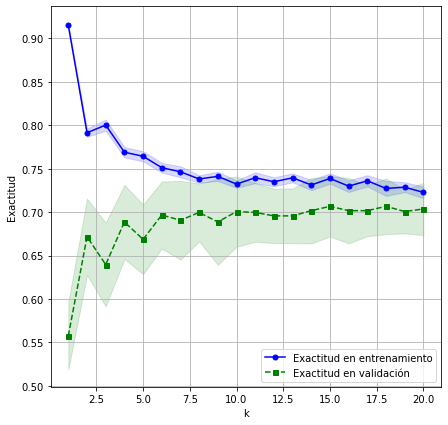

In [21]:
# Inicializamos la figura
plt.figure(figsize=(7,7))

# Creamos la curva de validación para el conjunto de entrenamiento
plt.plot(k_values, train_mean, color='blue', marker='o', markersize=5, label='Exactitud en entrenamiento')
plt.fill_between(k_values, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

# Creamos la curva de validación para el conjunto de validación
plt.plot(k_values, val_mean, color='green', linestyle='--', marker='s', markersize=5, label='Exactitud en validación')
plt.fill_between(k_values, val_mean+val_std, val_mean-val_std, alpha=0.15, color='green')

# Agregamos una grilla y etiquetas para los ejes
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('k')
plt.ylabel('Exactitud')
plt.show()

Un posible criterio de selección del mejor valor de _k_ es el valor de exactitud más alto en el conjunto de validación. Utilizando `np.argmax()`, podemos obtener el índice de `val_mean` en el que se encuentra el valor más alto:

In [22]:
mejor_indice = np.argmax(val_mean)
mejor_indice

14

Como el valor obtenido es un índice, podemos obtener el valor de _k_ obteniendo el elemento correspondiente de la lista `k_values`:

In [23]:
mejor_k = k_values[mejor_indice]
mejor_k

15

Como puedes observar, el mejor modelo tiene un valor de `n_neighbors=15`. Opcionalmente, puedes realizar una búsqueda utilizando `GridSearchCV` para verificar si se obtiene el mismo valor de _k_. Crearemos el mejor modelo utilizando este valor, y lo entrenaremos sobre el conjunto de entrenamiento mediante la función `fit()`, almacenando el resultado en la variable `mejor_modelo`:

In [24]:
mejor_modelo = KNeighborsClassifier(n_neighbors=mejor_k).fit(x_train, y_train)

En KNN se verifica la clase a la que pertenecen los _k_ datos más cercanos (usando, por defecto, la distancia euclidiana) a un dato que queremos clasificar. Para realizar la clasificación, se realiza una votación entre los _k_ datos, retornando la clase mayoritaria entre ellos. Para este problema, veremos los 15 datos más cercanos para predecir si una persona va a comprar un seguro de viaje o no.

## 6. Evaluación del mejor modelo

Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [25]:
x_test = test.drop(['TravelInsurance'],axis=1)
y_test = test['TravelInsurance']

Adicionalmente, escalaremos las variables descriptoras con la información disponible en el conjunto de entrenamiento, utilizando el método `transform()`:

In [26]:
x_test = scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=columns)
x_test

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,0.761248,-0.230174,0.629136,-0.715085,1.519193,-1.519193,-0.454447,0.454447,0.560780,-0.560780,0.492481,-0.492481
1,-0.593739,0.459107,-0.507404,1.398435,-0.658244,0.658244,-0.454447,0.454447,0.560780,-0.560780,0.492481,-0.492481
2,-0.593739,-1.746592,1.765676,-0.715085,1.519193,-1.519193,-0.454447,0.454447,0.560780,-0.560780,0.492481,-0.492481
3,-0.593739,0.734819,0.629136,1.398435,-0.658244,0.658244,-0.454447,0.454447,0.560780,-0.560780,0.492481,-0.492481
4,-0.593739,1.424100,-1.075675,-0.715085,-0.658244,0.658244,-0.454447,0.454447,-1.783232,1.783232,-2.030536,2.030536
...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.761248,-0.230174,1.197406,-0.715085,1.519193,-1.519193,-0.454447,0.454447,-1.783232,1.783232,-2.030536,2.030536
246,1.438741,-1.195167,-0.507404,-0.715085,-0.658244,0.658244,-0.454447,0.454447,0.560780,-0.560780,0.492481,-0.492481
247,1.438741,1.561956,-0.507404,1.398435,-0.658244,0.658244,-0.454447,0.454447,-1.783232,1.783232,-2.030536,2.030536
248,0.422501,0.872675,-0.507404,-0.715085,-0.658244,0.658244,-0.454447,0.454447,-1.783232,1.783232,-2.030536,2.030536


A continuación realizaremos predicciones sobre el conjunto de pruebas para comparar con los valores de `y_test`. Utilizaremos la función `predict()` sobre el mejor modelo:

In [27]:
y_pred = mejor_modelo.predict(x_test)

Ahora utilizaremos la función `plot_confusion_matrix()` para generar un mapa de calor con los valores de la matriz de confusión:

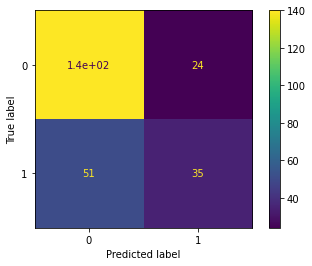

In [28]:
plot_confusion_matrix(mejor_modelo, x_test, y_test)  
plt.show()

Como puedes observar, el modelo tiende a predecir correctamente la clase 0, es decir, los elementos de la clase mayoritaria. De hecho, para la clase 1, el modelo tiende a predecir erróneamente. Específicamente, podemos observar las métricas de desempeño usando `classification_report()`:

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79       164
           1       0.59      0.41      0.48        86

    accuracy                           0.70       250
   macro avg       0.66      0.63      0.64       250
weighted avg       0.68      0.70      0.68       250



De manera similar al modelo de regresión logística y de árboles de decisión, en este modelo se tienen valores altos en la sensibilidad y precisión de la clase 0. Como la clase 1 no tiene tanta representación, tiene una sensibilidad y una precisión bastante bajas.

### Ejemplo de clasificación

Ahora veremos cómo se realiza una clasificación sobre un único dato. Empezaremos definiendo la variable `x_clasif` con uno de los valores del conjunto de test. Ten en cuenta que realizaremos nuestra predicción partiendo de la variable `x_test`, por lo que nuestro dato está codificado y estandarizado:

In [30]:
x_clasif = x_test.iloc[1]
x_clasif

Age                                            -0.593739
AnnualIncome                                    0.459107
FamilyMembers                                  -0.507404
ChronicDiseases                                 1.398435
Employment Type_Government Sector              -0.658244
Employment Type_Private Sector/Self Employed    0.658244
GraduateOrNot_No                               -0.454447
GraduateOrNot_Yes                               0.454447
FrequentFlyer_No                                0.560780
FrequentFlyer_Yes                              -0.560780
EverTravelledAbroad_No                          0.492481
EverTravelledAbroad_Yes                        -0.492481
Name: 1, dtype: float64

Utilizaremos `predict` para realizar la clasificación. Esta función necesita un arreglo de datos, por lo que pasaremos como parámetro un arreglo con una única posición. Almacenaremos el resultado en la variable `y_clasif`:

In [31]:
y_clasif = mejor_modelo.predict([x_clasif])
y_clasif

array([0])

Como puedes observar, el resultado de la predicción es un entero que representa la clase predicha. Para el dato `x_clasif`, el modelo de KNN predice que no va a comprar un seguro de viaje.